# PoseNet for Self-Localization Task on Apolloscape Dataset

PoseNet implementation on Apolloscape dataset. It's a part of the localization methods exploration for Apolloscape Self-Localization Challenge on [ECCV 2018](http://apolloscape.auto/ECCV/challenge.html)

In [1]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

`APOLLO_PATH` is a location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack it to the `APOLLO_PATH` dir. Let's we've symbolically linked `APOLLO_PATH` folder to `./data/apolloscape`.

In [2]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])


train_record = None # 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = None # 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)


print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=40) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=40) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: True
    Normalize Poses: True
    Length: 1121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: False
    Normalize Poses: True
    Length: 378 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



## Draw Train and Val datasets

Visualize poses from `train` and `val` datasets to check that it covers all val path.

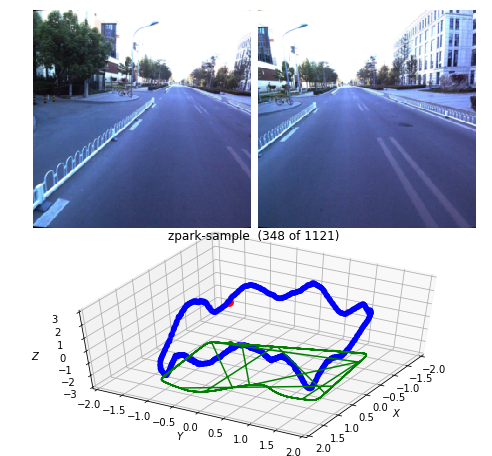

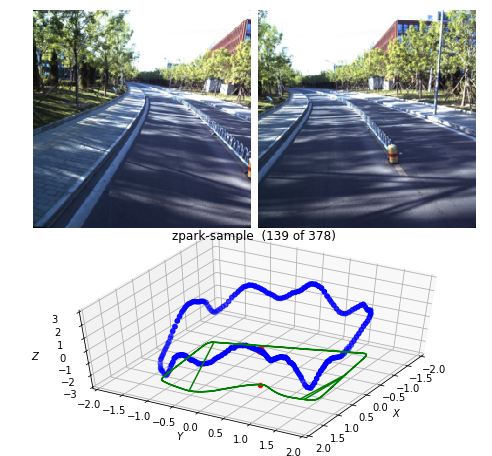

In [3]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()


## Device set up

Determine the primary device and use it for training/validation.

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

Train function runs one epoch through training data.

In [5]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True,
          poses_mean=None, poses_std=None):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # move data to cpu & numpy
        bp = [x.detach().cpu().numpy() for x in batch_poses]
        outp = [x.detach().cpu().numpy() for x in out]
        gt_poses = np.vstack((gt_poses, *bp))
        pred_poses = np.vstack((pred_poses, *outp))
        
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))

            
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     if unnorm:
#         print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
#     print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
#     print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

            
    if print_sum:
        print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s'.format(
            epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
            (time.time() - epoch_time)))
        
#     return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
                                                                               (time.time() - epoch_time)))
        
#     return losses.avg


## Create Model, Criterion and Optimizer

PoseNet implementation is a ResNet based feature extractor that ends with custom fully-connected regressor layers for translation (3D pose) and rotation (quaternion).

In [6]:
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
feature_extractor = models.resnet34(pretrained=False)
# feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion(stereo=True, beta=200.0)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=6e-6, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

It helps to continue training later or just use it for the inference.

In [7]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180806_151535_apollo_zpark_all_w34_2048L2_e1250.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


Loading from checkpoint: _checkpoints/20180806_151535_apollo_zpark_all_w34_2048L2_e1250.pth.tar


## Run Training

Training loop that runs for `n_epochs` with validation every `val_freq` epochs.

In [ ]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
n_epochs = start_epoch + 700

print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
         poses_mean=train_dataset.poses_mean, poses_std=train_dataset.poses_std)
    if e % val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=0)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Ep: [1250/1949]	Train Loss: 8.501	Te: 92.191	Re: 4.005	 Et: 21.86s
Epoch: [1250]	Validation Loss: 28.039	Epoch time: 5.500
Ep: [1251/1949]	Train Loss: 7.982	Te: 91.430	Re: 4.204	 Et: 21.80s
Ep: [1252/1949]	Train Loss: 8.556	Te: 91.114	Re: 4.492	 Et: 21.83s
Ep: [1253/1949]	Train Loss: 9.598	Te: 89.858	Re: 4.658	 Et: 21.67s
Ep: [1254/1949]	Train Loss: 9.926	Te: 90.366	Re: 5.034	 Et: 21.71s
Ep: [1255/1949]	Train Loss: 8.072	Te: 90.203	Re: 3.640	 Et: 21.57s
Epoch: [1255]	Validation Loss: 25.558	Epoch time: 5.535
Ep: [1256/1949]	Train Loss: 6.863	Te: 92.981	Re: 3.076	 Et: 21.57s
Ep: [1257/1949]	Train Loss: 7.443	Te: 90.823	Re: 3.741	 Et: 22.23s
Ep: [1258/1949]	Train Loss: 5.893	Te: 88.655	Re: 2.721	 Et: 21.82s
Ep: [1259/1949]	Train Loss: 6.380	Te: 88.184	Re: 3.120	 Et: 22.04s
Ep: [1260/1949]	Train Loss: 5.353	Te: 88.137	Re: 2.434	 Et: 21.70s
Epoch: [1260]	Validation Loss: 24.759	Epoch time: 5.498
Ep: [1261/1949]	Train Loss: 6.962	Te: 87.373	Re: 3.019	 Et: 21.62s
Ep: [1262/1949]

Ep: [1360/1949]	Train Loss: 5.533	Te: 79.405	Re: 2.336	 Et: 21.71s
Epoch: [1360]	Validation Loss: 24.313	Epoch time: 5.497
Ep: [1361/1949]	Train Loss: 6.036	Te: 82.662	Re: 2.940	 Et: 21.72s
Ep: [1362/1949]	Train Loss: 6.948	Te: 81.378	Re: 3.434	 Et: 21.64s
Ep: [1363/1949]	Train Loss: 8.170	Te: 80.691	Re: 3.602	 Et: 21.69s
Ep: [1364/1949]	Train Loss: 5.702	Te: 79.230	Re: 2.627	 Et: 21.91s
Ep: [1365/1949]	Train Loss: 6.597	Te: 79.450	Re: 2.903	 Et: 21.80s
Epoch: [1365]	Validation Loss: 24.382	Epoch time: 5.536
Ep: [1366/1949]	Train Loss: 8.300	Te: 80.195	Re: 3.708	 Et: 21.68s
Ep: [1367/1949]	Train Loss: 6.282	Te: 79.408	Re: 2.782	 Et: 21.75s
Ep: [1368/1949]	Train Loss: 6.154	Te: 81.775	Re: 2.825	 Et: 21.79s
Ep: [1369/1949]	Train Loss: 6.097	Te: 80.317	Re: 2.837	 Et: 21.92s
Ep: [1370/1949]	Train Loss: 6.660	Te: 78.896	Re: 3.534	 Et: 21.78s
Epoch: [1370]	Validation Loss: 22.930	Epoch time: 5.536
Ep: [1371/1949]	Train Loss: 6.509	Te: 78.310	Re: 2.826	 Et: 21.45s
Ep: [1372/1949]	Train Loss: 

Ep: [1469/1949]	Train Loss: 4.386	Te: 67.636	Re: 2.016	 Et: 21.51s
Ep: [1470/1949]	Train Loss: 4.433	Te: 68.637	Re: 1.961	 Et: 21.65s
Epoch: [1470]	Validation Loss: 22.516	Epoch time: 5.473
Ep: [1471/1949]	Train Loss: 3.843	Te: 66.858	Re: 1.721	 Et: 21.53s
Ep: [1472/1949]	Train Loss: 4.778	Te: 67.758	Re: 2.027	 Et: 21.62s
Ep: [1473/1949]	Train Loss: 5.471	Te: 65.933	Re: 2.572	 Et: 21.65s
Ep: [1474/1949]	Train Loss: 5.547	Te: 67.387	Re: 2.691	 Et: 21.75s
Ep: [1475/1949]	Train Loss: 4.746	Te: 68.654	Re: 2.020	 Et: 21.84s
Epoch: [1475]	Validation Loss: 21.610	Epoch time: 5.511
Ep: [1476/1949]	Train Loss: 4.736	Te: 66.210	Re: 2.377	 Et: 21.87s
Ep: [1477/1949]	Train Loss: 4.720	Te: 67.803	Re: 2.448	 Et: 21.80s
Ep: [1478/1949]	Train Loss: 5.497	Te: 66.991	Re: 2.629	 Et: 21.84s
Ep: [1479/1949]	Train Loss: 6.393	Te: 67.888	Re: 3.047	 Et: 21.61s
Ep: [1480/1949]	Train Loss: 6.689	Te: 69.414	Re: 3.395	 Et: 21.74s
Epoch: [1480]	Validation Loss: 21.671	Epoch time: 5.564
Ep: [1481/1949]	Train Loss: 

Ep: [1574/1949]	Train Loss: 5.206	Te: 60.542	Re: 2.597	 Et: 21.56s
Ep: [1575/1949]	Train Loss: 5.458	Te: 59.355	Re: 2.473	 Et: 21.74s
Epoch: [1575]	Validation Loss: 22.692	Epoch time: 5.478
Ep: [1576/1949]	Train Loss: 5.692	Te: 59.809	Re: 2.849	 Et: 21.65s
Ep: [1577/1949]	Train Loss: 6.364	Te: 61.572	Re: 2.885	 Et: 21.80s
Ep: [1578/1949]	Train Loss: 5.739	Te: 61.170	Re: 2.674	 Et: 21.55s
Ep: [1579/1949]	Train Loss: 5.106	Te: 61.231	Re: 2.530	 Et: 21.64s
Ep: [1580/1949]	Train Loss: 6.153	Te: 60.394	Re: 3.006	 Et: 21.71s
Epoch: [1580]	Validation Loss: 19.332	Epoch time: 5.527
Ep: [1581/1949]	Train Loss: 5.646	Te: 60.219	Re: 2.425	 Et: 21.63s
Ep: [1582/1949]	Train Loss: 5.186	Te: 60.267	Re: 2.277	 Et: 21.66s
Ep: [1583/1949]	Train Loss: 4.811	Te: 59.026	Re: 1.995	 Et: 21.59s
Ep: [1584/1949]	Train Loss: 5.210	Te: 59.749	Re: 2.525	 Et: 21.64s
Ep: [1585/1949]	Train Loss: 6.056	Te: 59.721	Re: 2.723	 Et: 21.51s
Epoch: [1585]	Validation Loss: 22.841	Epoch time: 5.563
Ep: [1586/1949]	Train Loss: 

## Test Model Error on Validation and Train Datasets

Calculate translation and rotation error of the predicted poses on train and validation datasets.

In [ ]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]

        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
        out = [x.detach().cpu().numpy() for x in out]

        gt_poses = np.vstack((gt_poses, *batch_poses))
        pred_poses = np.vstack((pred_poses, *out))
        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses


# Get mean and std from dataset
poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std



print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses


print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses



### Visualize Prediction and Ground Truth Poses

Draw ground truth in `blue` and predictions in `red` colors.

In [ ]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('PoseNet on Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('PoseNet on Validation Dataset')
plt.show()



## Save Model Checkpoint

In [ ]:
# Save checkpoint
# n_epochs = 1068
save_checkpoint(model, optimizer, 'apollo_zpark_all_w34_2048L2', n_epochs)
    